In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from analysis.datasets import load_entsoe
from analysis.splits import to_train_validation_test_data
from analysis.transformations import scale_power_data
from tabpfn import TabPFNRegressor
from analysis.transformations import add_interval_index, add_lagged_features
from torchinfo import summary
from analysis.TabPFN_copy import evaluate
import torch
import seaborn as sns
from analysis.TabPFN_copy import fit_tail_distribution, plot_cdf_pdf_dynamic, plot_pdf_from_logits
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load data
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
)

# Initialize a regressor
reg = TabPFNRegressor()
reg.fit(X_train, y_train)

# Predict a point estimate (using the mean)
predictions = reg.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predictions))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predictions))
print("R-squared (R^2):", r2_score(y_test, predictions))

# Predict quantiles
quantiles = [0.25, 0.5, 0.75]
quantile_predictions = reg.predict(
    X_test,
    output_type="quantiles",
    quantiles=quantiles,
)
for q, q_pred in zip(quantiles, quantile_predictions):
    print(f"Quantile {q} MAE:", mean_absolute_error(y_test, q_pred))

# Predict with mode
mode_predictions = reg.predict(X_test, output_type="mode")
print("Mode MAE:", mean_absolute_error(y_test, mode_predictions))


full_output = reg.predict(X_test, output_type="full")
logits = full_output["logits"]

c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Mean Squared Error (MSE): 2688.2340718882
Mean Absolute Error (MAE): 41.05663142792166
R-squared (R^2): 0.5329083100989893


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Quantile 0.25 MAE: 52.732839584350586
Quantile 0.5 MAE: 41.18152926719352
Quantile 0.75 MAE: 49.68900293846653


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mode MAE: 47.37220016897541


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [7]:
pd.DataFrame(logits)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,-inf,-24.753813,-26.840052,-27.526920,-27.048717,-27.915060,-28.355930,-28.110603,-28.154871,-28.346195,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.923214
1,-inf,-24.014349,-25.982546,-26.688499,-26.204599,-27.129553,-27.552353,-27.279367,-27.363989,-27.436073,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.769064
2,-inf,-24.556295,-26.661901,-27.372540,-26.920361,-27.800892,-28.254534,-28.017435,-28.072514,-28.247643,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.006924
3,-inf,-21.530546,-23.241230,-24.265295,-23.692362,-24.750593,-25.154928,-24.818462,-24.955210,-24.765257,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.230068
4,-inf,-25.053526,-27.213121,-27.904863,-27.449492,-28.278128,-28.761446,-28.523413,-28.538313,-28.820169,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.230068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,-inf,-24.528090,-26.501749,-27.253443,-26.767305,-27.706137,-28.130537,-27.838823,-27.935524,-27.961582,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.150024
142,-inf,-23.792271,-25.626274,-26.430634,-25.956505,-26.937151,-27.341494,-27.024645,-27.150204,-27.060951,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.412390
143,-inf,-24.073683,-26.254114,-27.007648,-26.601059,-27.400311,-27.982193,-27.770033,-27.756083,-28.157667,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.769064
144,-inf,-23.390772,-25.293522,-26.106174,-25.634420,-26.615007,-27.031403,-26.725197,-26.855530,-26.807974,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-16.006924


In [22]:
id = 5
borders_q = full_output["criterion"].borders
y_validation_q_torch = torch.tensor(y_test, dtype=torch.float32)
probs = torch.softmax(logits, dim=1)  # (N, 5000)
cdf = torch.cumsum(probs, dim=1)  # (N, 5000)
indicators = (borders_q[1:].unsqueeze(0) >= y_validation_q_torch.unsqueeze(1)).float()  # (N, 5000)
bin_widths = (borders_q[1:] - borders_q[:-1]).unsqueeze(0)  # (1, 5000)

# Assuming logits_2 is a tensor of shape (N, 5000)
probs_t = torch.softmax(logits, dim=1)  # Convert logits to probabilities (N, 5000)
probs_np = probs_t[id, :].cpu().numpy()  # Convert first sample to NumPy (1D array)

In [62]:
cdf.shape

torch.Size([146, 5000])

torch.Size([5000])

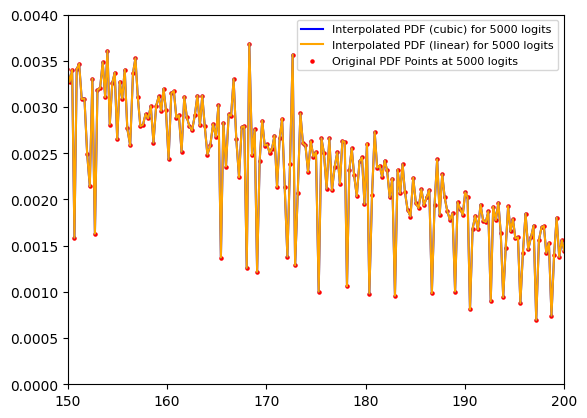

In [95]:
import scipy.interpolate as spi


# Convert bin borders to NumPy if necessary
borders_np = borders_q.cpu().numpy() if isinstance(borders_q, torch.Tensor) else np.array(borders_q)

# Compute bin widths (size 5000)
bin_widths = np.diff(borders_np)  # Difference between consecutive bin edges

# Compute PDF values (divide probability mass by bin width)
pdf_values = probs_np / bin_widths  # Element-wise division

# Compute bin midpoints
midpoints = (borders_np[:-1] + borders_np[1:]) / 2  # Midpoints of bins

# Create an interpolation function using midpoints
pdf_function_linear = spi.interp1d(
midpoints, pdf_values, kind='linear', fill_value="extrapolate", bounds_error=False
)

pdf_function_pchip = spi.CubicSpline(
midpoints, pdf_values, extrapolate=True)

cdf_values = cdf[id,:]

cdf_function_linear = spi.interp1d(
midpoints, cdf_values, kind='cubic', fill_value="extrapolate", bounds_error=False
)
# Generate x values for plotting
#x_plot = np.linspace(midpoints[0], midpoints[-1], 50000)  # Smooth x range
x_plot = midpoints
y_plot = pdf_function_pchip(x_plot)  # Evaluate the PDF function
y_plot_2 = pdf_function_linear(x_plot)  # Evaluate the PDF function
epsilon = 5
y_plot_3 = (cdf_function_linear(x_plot + epsilon) - cdf_function_linear(x_plot + epsilon)) / (2 * epsilon)
# Plot the PDF
#plt.set_xlim(x_lim)  # Use externally defined limits
#plt.set_ylim(y_lim)  
plt.plot(x_plot, y_plot, label="Interpolated PDF (cubic) for 5000 logits", color="blue")
plt.plot(x_plot, y_plot_2, label="Interpolated PDF (linear) for 5000 logits", color="orange")
#plt.plot(x_plot, y_plot_3, label="Interpolated PDF (differentiated cdf) for 5000 logits")

case = 2
if case == 1:
    plt.yscale("log")
    plt.ylim(1e-5, 2e-2)
    plt.xlim(0, 300)

elif case == 2:
    plt.yscale("linear")
    plt.xlim(150, 200)
    plt.ylim(0, 0.004)

plt.scatter(midpoints, pdf_values, color="red", s=5, label="Original PDF Points at 5000 logits")  
plt.legend(loc='upper right', fontsize=8)


Dies zeigt die Verteilung, die TabPFN für einen Datenpunkt eines Demodatensatzes (sklearn diabetes). Das sieht aus wie eine schmale Normalverteilung. Wenn man reinzoomt stellt man fest, dass die PDF-Werte von einem bin zum nächsten fluktuieren.

In [71]:
cdf_function_linear(70)

array(0.3268156)

In [60]:
y_plot_3.shape

(146, 5000)

In [59]:
x_plot.shape

(5000,)

In [ ]:
cdf_function_linear = spi.interp1d(
midpoints, cdf, kind='linear', fill_value="extrapolate", bounds_error=False
)

